In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
latent_size = 100
image_size = 64
num_epochs = 20
batch_size = 128
learning_rate = 0.0002

In [ ]:
# Controlla la disponibilità della GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5), std=(0.5))
])

train_dataset = datasets.EMNIST(root='./data', train=True,split='mnist', download=True, transform=transform)
test_dataset = datasets.EMNIST(root='./data', train=False, download=True,split='mnist', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Esempi dal training set:


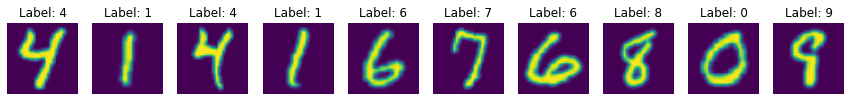

In [ ]:
def show_images(dataset, num_images=10):
    # Crea una griglia di immagini da visualizzare
    fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(15,5))

    # Seleziona alcune immagini casuali dal dataset
    images, labels = zip(*[dataset[i] for i in range(num_images)])
  
    # Visualizza le immagini con le etichette corrispondenti
    for i, ax in enumerate(axes):
        ax.imshow(images[i].squeeze().cpu().numpy().T)
        ax.set_title(f'Label: {labels[i]}')
        ax.axis('off')
    
    plt.show()

# Stampa alcuni campioni dal dataset
print('Esempi dal training set:')
show_images(train_dataset)


In [ ]:
train_dataset[0][0].shape

torch.Size([1, 64, 64])

# Generative Adversarial Networks
[Paper](https://proceedings.neurips.cc/paper/2014/file/5ca3e9b122f61f8f06494c97b1afccf3-Paper.pdf)

[Tutorial DCGAN](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)

Le Generative Adversarial Networks (GANs), sono una tecnica di deep learning che prevede l'uso di due reti neurali, una generativa e una discriminante, che lavorano insieme per generare nuovi dati "falsi" simili a quelli "veri". La rete generativa cerca di creare dati artificiali che sembrano realistici, mentre la rete discriminante cerca di distinguere i dati generati dalla rete generativa da quelli reali. In questo modo, le due reti "competono" e migliorano insieme, fino a quando la rete generativa è in grado di produrre dati molto simili a quelli reali. Le GANs sono utilizzati in molti campi, come l'elaborazione delle immagini e la generazione di testo.

In [ ]:
# custom weights initialization 
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
# Generator model
#Reti prese da: 
class Generator(nn.Module):
    # initializers
    def __init__(self, d=64):
        super(Generator, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(100, d*8, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(d*8)
        self.deconv2 = nn.ConvTranspose2d(d*8, d*4, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*4)
        self.deconv3 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d*2)
        self.deconv4 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d)
        self.deconv5 = nn.ConvTranspose2d(d, 1, 4, 2, 1)


    # forward method
    def forward(self, input):
        x = nn.functional.relu(self.deconv1_bn(self.deconv1(input)))
        x = nn.functional.relu(self.deconv2_bn(self.deconv2(x)))
        x = nn.functional.relu(self.deconv3_bn(self.deconv3(x)))
        x = nn.functional.relu(self.deconv4_bn(self.deconv4(x)))
        x = torch.tanh(self.deconv5(x))

        return x

class Discriminator(nn.Module):
    # initializers
    def __init__(self, d=64):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, d*8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(d*8)
        self.conv5 = nn.Conv2d(d*8, 1, 4, 1, 0)


    # forward method
    def forward(self, input):
        x = nn.functional.leaky_relu(self.conv1(input), 0.2)
        x = nn.functional.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = nn.functional.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = nn.functional.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = torch.sigmoid(self.conv5(x))

        return x


In [ ]:
def print_samples(generator, num_samples=16, noise_dim=100):
    # Generiamo del rumore casuale
    noise = torch.randn((num_samples, noise_dim,1,1)).to(device)*0.7
    fake_images = generator(noise)
    
    # Rescaliamo i valori dal range [-1, 1] al range [0, 1]
    fake_imagess = (fake_images + 1) / 2.0
    
    # Creiamo una griglia di campioni e la stampiamo
    fig, ax = plt.subplots(4, 4, figsize=(10, 10))
    for i in range(4):
        for j in range(4):
            ax[i, j].imshow(fake_images[i*4+j].squeeze().detach().cpu().numpy().T, cmap='gray')
            ax[i, j].axis('off')
    
    plt.show()

In [ ]:
# Initialize models
G = Generator().to(device)
D = Discriminator().to(device)
G.apply(weights_init)
D.apply(weights_init)
# Loss function
criterion = nn.BCELoss()

# Optimizers
G_optimizer = optim.Adam(G.parameters(), lr=learning_rate, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=learning_rate, betas=(0.5, 0.999))

In [ ]:
summary(D,(1,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,088
            Conv2d-2          [-1, 128, 16, 16]         131,200
       BatchNorm2d-3          [-1, 128, 16, 16]             256
            Conv2d-4            [-1, 256, 8, 8]         524,544
       BatchNorm2d-5            [-1, 256, 8, 8]             512
            Conv2d-6            [-1, 512, 4, 4]       2,097,664
       BatchNorm2d-7            [-1, 512, 4, 4]           1,024
            Conv2d-8              [-1, 1, 1, 1]           8,193
Total params: 2,764,481
Trainable params: 2,764,481
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 1.38
Params size (MB): 10.55
Estimated Total Size (MB): 11.94
----------------------------------------------------------------


In [ ]:
summary(G,(100,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,712
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
   ConvTranspose2d-3            [-1, 256, 8, 8]       2,097,408
       BatchNorm2d-4            [-1, 256, 8, 8]             512
   ConvTranspose2d-5          [-1, 128, 16, 16]         524,416
       BatchNorm2d-6          [-1, 128, 16, 16]             256
   ConvTranspose2d-7           [-1, 64, 32, 32]         131,136
       BatchNorm2d-8           [-1, 64, 32, 32]             128
   ConvTranspose2d-9            [-1, 1, 64, 64]           1,025
Total params: 3,575,617
Trainable params: 3,575,617
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.91
Params size (MB): 13.64
Estimated Total Size (MB): 15.55
-------------------------------------

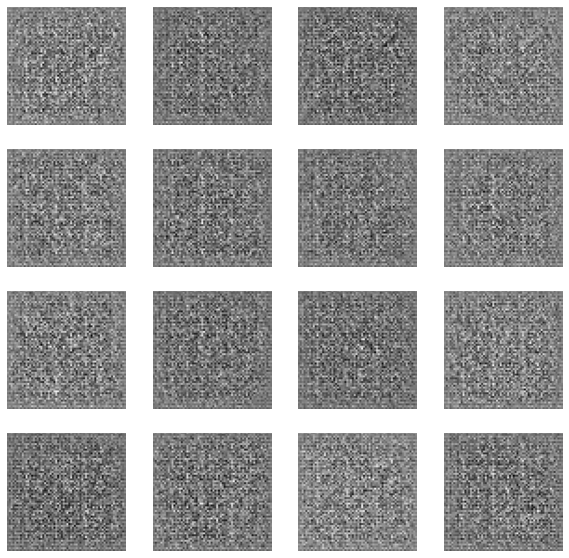

In [ ]:
print_samples(G)

La loss function (funzione di perdita) di una GAN con un generatore (G) e un discriminante (D) può essere espressa come:

$$min_Gmax_D\mathcal{L}(G, D) = \mathbb{E}_{x \sim p_{\text{data}}(x)}[\log D(x)] + \mathbb{E}_{z \sim p_z(z)}[\log(1 - D(G(z)))]$$

dove:

$p_{\text{data}}(x)$ è la distribuzione di probabilità dei dati reali.
$p_z(z)$ è la distribuzione di probabilità del rumore di input per il generatore.
$x$ rappresenta un'immagine reale.
$z$ rappresenta il rumore di input per il generatore.
$G(z)$ rappresenta un'immagine generata dal generatore usando il rumore $z$.
$D(x)$ rappresenta la probabilità che l'immagine $x$ sia reale (cioè appartiene alla distribuzione $p_{\text{data}}$).
$D(G(z))$ rappresenta la probabilità che l'immagine generata $G(z)$ sia reale (cioè appartiene alla distribuzione $p_{\text{data}}$).
La funzione di perdita della GAN cerca di massimizzare la probabilità che il discriminante classifichi correttamente sia le immagini reali che quelle generate dal generatore, minimizzando così la distanza tra le due distribuzioni di probabilità $p_{\text{data}}$ e $p_{\text{model}}$, dove $p_{\text{model}}$ rappresenta la distribuzione di probabilità dei dati generati dal generatore.

In [ ]:
def train_gan(discriminator, generator, dataloader,batch_size, num_epochs, device):
    # Set up loss functions and optimizers
    criterion = nn.BCELoss()
    # Move models to device
    discriminator.to(device)
    generator.to(device)

    for epoch in tqdm(range(num_epochs)):
        for i, data in enumerate(dataloader):
            # Move real images to device
            real_images,_= data
            real_images = real_images.to(device)
            # Set up labels for real and fake images
            real_labels = torch.ones(real_images.shape[0]).to(device)
            fake_labels = torch.zeros(real_images.shape[0]).to(device)

            # Train discriminator
            discriminator.zero_grad()
            real_outputs = discriminator(real_images).squeeze()
            d_loss_real = criterion(real_outputs, real_labels)
            d_loss_real.backward()

            noise = torch.randn(real_images.shape[0], 100,1,1).to(device)
            fake_images = generator(noise)
            fake_outputs = discriminator(fake_images.detach()).squeeze()

            
            d_loss_fake = criterion(fake_outputs, fake_labels)
            d_loss_fake.backward()

            d_loss = d_loss_real + d_loss_fake
            D_optimizer.step()

            # Train generator
            generator.zero_grad()
            fake_outputs = discriminator(fake_images).squeeze()
            g_loss = criterion(fake_outputs, real_labels)
            g_loss.backward()
            G_optimizer.step()

            if i % 100 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Discriminator Loss: {:.4f}, Generator Loss: {:.4f}'
                      .format(epoch, num_epochs, i, len(dataloader), d_loss.item(), g_loss.item()))


In [ ]:
train_gan(D, G, train_loader,batch_size, num_epochs, device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [0/20], Step [0/469], Discriminator Loss: 3.6580, Generator Loss: 10.5956
Epoch [0/20], Step [100/469], Discriminator Loss: 0.1038, Generator Loss: 4.7077
Epoch [0/20], Step [200/469], Discriminator Loss: 0.3737, Generator Loss: 2.2369
Epoch [0/20], Step [300/469], Discriminator Loss: 0.5778, Generator Loss: 2.0026
Epoch [0/20], Step [400/469], Discriminator Loss: 0.6617, Generator Loss: 2.6972
Epoch [1/20], Step [0/469], Discriminator Loss: 0.5299, Generator Loss: 1.6152
Epoch [1/20], Step [100/469], Discriminator Loss: 0.6972, Generator Loss: 1.2637
Epoch [1/20], Step [200/469], Discriminator Loss: 2.1120, Generator Loss: 3.1072
Epoch [1/20], Step [300/469], Discriminator Loss: 1.4578, Generator Loss: 1.1860
Epoch [1/20], Step [400/469], Discriminator Loss: 0.6054, Generator Loss: 2.6407
Epoch [2/20], Step [0/469], Discriminator Loss: 0.4966, Generator Loss: 1.6619
Epoch [2/20], Step [100/469], Discriminator Loss: 0.8641, Generator Loss: 1.5280
Epoch [2/20], Step [200/469], Dis

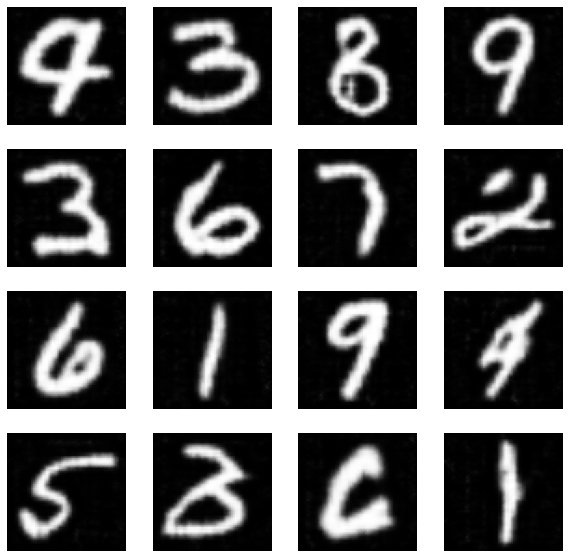

In [ ]:
print_samples(G)

Approfondimenti: 
* CycleGAN: [Tutorial](https://www.tensorflow.org/tutorials/generative/cyclegan?hl=it) (Keras) [Paper](https://arxiv.org/pdf/1703.10593.pdf)